In [ ]:
# 이항 분류, 숫자 이미지의 짝수/홀수 판별, MLP, GPU, Colab

In [1]:
# 글꼴 설치전 런타임 환경 확인
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
from google.colab import drive
drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

Mounted at /content/drive


In [1]:
# %autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os 
import random
import sys
import time
from time import localtime, strftime

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sb
import cv2

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    # rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/mnist' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 10         # 글자 크기
plt.rcParams["figure.figsize"] = (4, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ----------------------------------------------------------------
# OS
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
# ----------------------------------------------------------------

In [2]:
# 최초에만 다운로드 발생
(x_train, y_train), (x_test, y_test)  = mnist.load_data()
width=28
height=28

print('x_train.shape:', x_train.shape)

# 훈련 데이터 3차원 -> 2차원으로 변형, 60000행  X 784열
x_train = x_train.reshape(x_train.shape[0], width * height).astype('float32') / 255 
print('x_train.shape:', x_train.shape)

# 10000행 X 784열
x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 

x_train.shape: (60000, 28, 28)
x_train.shape: (60000, 784)


In [3]:
# 이항 분류 변환
# 홀수는 1, 짝수는 0
y_train = y_train % 2

print('Target:', y_test[0:10])
y_test = y_test % 2
print('이항분류가 적용된 Target:', y_test[0:10])
# 0, 2, 4, 6, 8 학습시 0이라고 학습 시킴
# 1, 3, 5, 7, 9 학습시 1이라고 학습 시킴

Target: [7 2 1 0 4 1 4 9 5 9]
이항분류가 적용된 Target: [1 0 1 0 0 1 0 1 1 1]


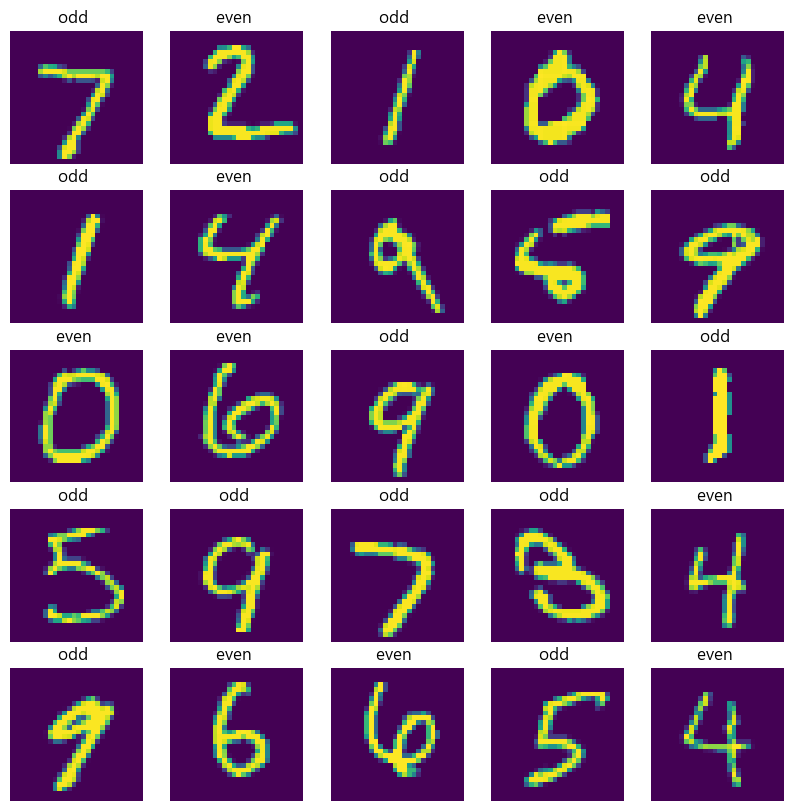

In [4]:
# 데이터 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row * plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i // plt_row, i % plt_col] # 행, 열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 2차원 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = '' 
    
    if y_test[i] :  # 1: True, 0: False
        sub_plt_title += 'odd '  # 1, 홀수
    else:
        sub_plt_title += 'even ' # 0, 짝수
    
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()

In [5]:
# 네트워크 구성
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

# 데이터 준비
(x_train, y_train), (x_test, y_test) = mnist.load_data()
width=28
height=28

# 기존 데이터에 색상 정보 추가
# 데이터가 0 부터 255로 구성되어 있음으로 255로 나누어서 정규화
# 28 x 28 필셀의 흑백이미지(1) 60000장 구조 생성
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255.0
# 28 x 28 필셀의 흑백이미지(1) 10000장 구조 생성
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255.0

# 데이터셋 전처리 : 홀수는 1, 짝수는 0으로 변환
# 0: 0, 2, 4, 6, 8
# 1: 1, 3, 5, 7, 9
y_train = y_train % 2 
y_test = y_test % 2

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (28, 28, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달, 슬라이딩이 작동되어 파라미터수가 50%로 감소함 
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', 
                                metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)
start = time.time()
# 장비 속도가 느려 3번만 진행
hist = model.fit(x_train, y_train, validation_split = 0.2, 
                 shuffle=True, epochs=3, 
                 batch_size=30, callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# Total params: 117,121 Colab gpu: 42 ~ 83s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                    

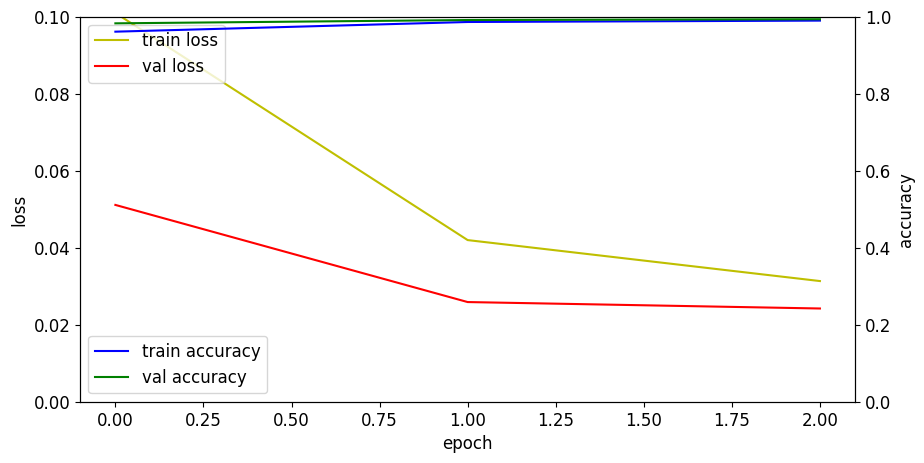

In [9]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.1]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=50, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')
# MLP 693,301개 손실값: 0.04711847007274628 /정확도: 98.4499990940094 %
# CNN 117,121개 손실값: 0.01749538816511631 /정확도: 99.44000244140625 %

손실값: 0.01749538816511631 /정확도: 99.44000244140625 %


In [11]:
model.save('./Mnist2_cnn.h5')

model = load_model('./Mnist2_cnn.h5')

yp = model.predict(x_test, batch_size=32)
print(yp[0:10])

313/313 [==============================] - 1s 2ms/step
[[9.9999964e-01]
 [2.6317834e-04]
 [9.9976236e-01]
 [1.2658062e-04]
 [4.2350814e-04]
 [9.9993181e-01]
 [1.6583594e-04]
 [9.9130452e-01]
 [7.6729745e-01]
 [9.9962246e-01]]


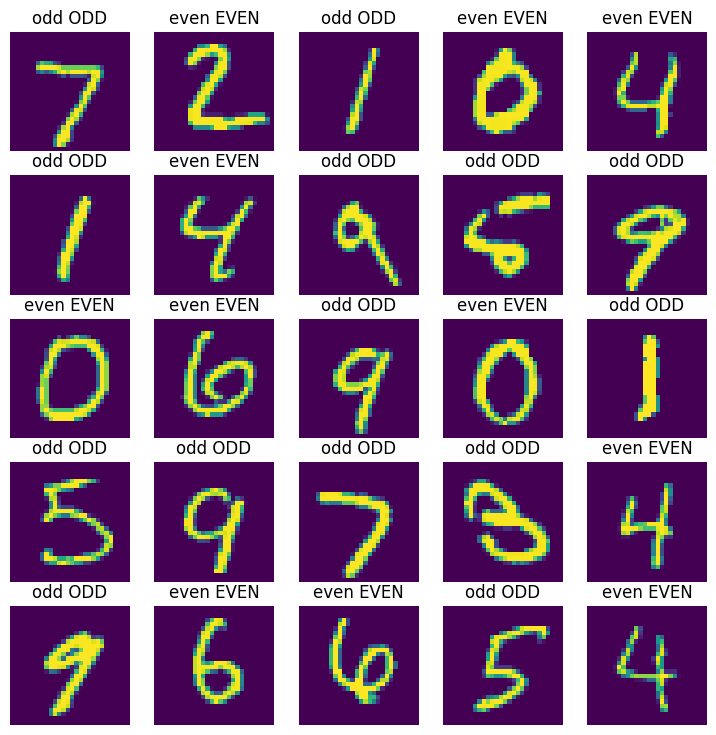

In [20]:
# 결과 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (9, 9) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row*plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i//5, i%5] # 행, 열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = '' 
    
    if y_test[i] :  # 1: True, 0: False, 찾아야할 값
        sub_plt_title += 'odd '  # 1, 홀수
    else:
        sub_plt_title += 'even ' # 0, 짝수
        
    # 예측한 값 출력
    if yp[i] >= 0.5:
        sub_plt_title += 'ODD'  # 예측값
    else:
        sub_plt_title += 'EVEN'
    
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()